In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
df_global = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet')

In [16]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

In [17]:
df_global['is_congested'] = df_global['code_couleur'].apply(lambda x : 0 if x == 3 else 1)

In [18]:
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')

train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()

In [19]:
test_df = pd.merge(
    df_prediction_taux_occupation,
    df_global,
    on=['heure_arrondie', 'nom_du_troncon']
)

In [20]:
# Selection des variables explicatives
feature_cols_train = ['taux_occupation', 'weekday', 'hour', 'minute','is_vacances', 'is_ferie', 'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 'precipitation', 'visibility','wind_speed_10m']
feature_cols_test = ['taux_occupation_pred', 'weekday', 'hour', 'minute','is_vacances', 'is_ferie', 'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 'precipitation', 'visibility','wind_speed_10m']
target_col = 'is_congested'

In [21]:
X_train = train_df[feature_cols_train]
X_test = test_df[feature_cols_test]
y_train = train_df['is_congested']

In [22]:
X_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)

<ipython-input-22-1835cdae1e2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)


In [23]:
# --- Entraînement du modèle ---
print("Entraînement du modèle")
model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)
print("Modèle entraîné.")

Entraînement du modèle
Modèle entraîné.


In [24]:
y_pred = model.predict(X_test)
X_test['is_congested_predit'] = y_pred

<ipython-input-24-b131c7a06ff9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['is_congested_predit'] = y_pred


In [25]:
y_true = test_df['is_congested']


--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    422099
           1       0.45      0.35      0.39      9325

    accuracy                           0.98    431424
   macro avg       0.72      0.67      0.69    431424
weighted avg       0.97      0.98      0.98    431424


--- Matrice de Confusion ---
Visualisation des erreurs de classification :


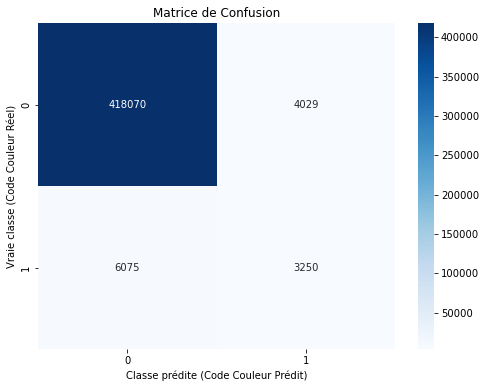

In [26]:
# Générer et afficher le Rapport de Classification
print("\n--- Rapport de Classification ---")
print(classification_report(y_true, y_pred))


# Matrice de confusion
print("\n--- Matrice de Confusion ---")
print("Visualisation des erreurs de classification :")

labels = sorted(y_true.astype(int).unique())

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Affichage 
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe (Code Couleur Réel)')
plt.xlabel('Classe prédite (Code Couleur Prédit)')
plt.show()